<a href="https://colab.research.google.com/github/Afzalfaizi/LangGraph/blob/main/module_1_node.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

**State**

First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.



In [2]:
from typing_extensions import TypedDict
class LearningState(TypedDict):
    prompt: str


In [3]:
# prompt: create an example from above LearningState
lahore_state: LearningState = LearningState(prompt= "hello from UMT Lahore")

In [4]:
print(lahore_state)
print(lahore_state['prompt'])
print(lahore_state['prompt'] +" I am")
print(lahore_state)
print(type(lahore_state))

{'prompt': 'hello from UMT Lahore'}
hello from UMT Lahore
hello from UMT Lahore I am
{'prompt': 'hello from UMT Lahore'}
<class 'dict'>


**Nodes**

Nodes are just python functions.

The first positional argument is the state, as defined above.

Because the state is a TypedDict with schema as defined above, each node can access the key, graph_state, with state['graph_state'].

Each node returns a new value of the state key graph_state.

By default, the new value returned by each node will override the prior state value.

In [5]:
def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)
    return {"prompt": state['prompt'] +" I am"}

def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)
    return {"prompt": state['prompt'] +" happy!"}

**Edges**

Edges connect the nodes.

Normal Edges are used if you want to always go from, for example, node_1 to node_2.

**Graph Construction**



Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a Mermaid diagram.

In [6]:
from IPython.display import Image, display # Preview Graph

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph # type

# Build graph
builder: StateGraph = StateGraph(state_schema=LearningState)

In [7]:
print(type(builder))

<class 'langgraph.graph.state.StateGraph'>


In [8]:
# Nodes in LangGraph
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

In [9]:
# Simples Edges Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

In [10]:
# Add
graph: CompiledStateGraph = builder.compile()

In [11]:
print(graph)

In [12]:
print(graph.get_graph())

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


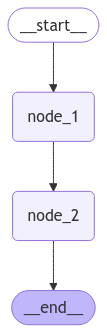

In [13]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

**Graph Invocation**
The compiled graph implements the runnable protocol.

This provides a standard way to execute LangChain components.

invoke is one of the standard methods in this interface.

The input is a dictionary {"graph_state": "Hi, this is lance."}, which sets the initial value for our graph state dict.

When invoke is called, the graph starts execution from the START node.

It progresses through the defined nodes (node_1, node_2, node_3) in order.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the END node.

In [14]:
graph.invoke({"prompt" : "Hi"})

---Node 1 State--- {'prompt': 'Hi'}
---Node 2 State--- {'prompt': 'Hi I am'}


{'prompt': 'Hi I am happy!'}

invoke runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it returns the state after node_3 has completed:

{'graph_state': 'Hi, this is Lance. I am sad!'}

**Task: In Nodes Use LLM == GoogleChatModel in Langchain**


In [15]:
%pip install -q -U langchain
%pip install -q -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 852.4 kB/s eta 0:00:00


In [17]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=google_api_key,     # Provide the Google API key for authentication
)

In [19]:
# Import the AIMessage class currently will be used for typing
from langchain_core.messages.ai import AIMessage

ai_msg: AIMessage = llm.invoke("Hi?")

In [20]:
print(ai_msg.content)
print(type(ai_msg.content))


Hi there! How can I help you today?

<class 'str'>


In [21]:
from typing_extensions import TypedDict

class FirstLLMAgentCall(TypedDict):
    prompt: str
    output: str

In [22]:
def node_1(state: FirstLLMAgentCall) -> FirstLLMAgentCall:
    print("---Node 1 State---", state)
    prompt = state["prompt"]
    ai_msg: AIMessage = llm.invoke(prompt)
    return {"output": ai_msg.content}

In [23]:
faizi_greet_message = node_1(FirstLLMAgentCall(prompt="Hi, I am Faizi from NTU. How are you?"))
print(faizi_greet_message)
print(type(faizi_greet_message))

---Node 1 State--- {'prompt': 'Hi, I am Faizi from NTU. How are you?'}
{'output': "I'm doing well, thank you for asking!  It's nice to meet you, Faizi from NTU.  How are you doing today?\n"}
<class 'dict'>


In [24]:
from IPython.display import Image, display_html
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

builder: StateGraph = StateGraph(state_schema=FirstLLMAgentCall)

# Define Nodes
builder.add_node("node_1", node_1)

# Simples Edges Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile Graph
graph: CompiledStateGraph = builder.compile()



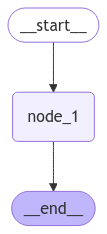

In [25]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
result = graph.invoke({"prompt": "can you motivate me to learn langGraph?"})
print(result)

---Node 1 State--- {'prompt': 'can you motivate me to learn langGraph?'}
{'prompt': 'can you motivate me to learn langGraph?', 'output': 'Let\'s talk about why learning LangGraph could be a fantastic investment of your time and energy.  It\'s not just another language model; it offers a unique blend of capabilities that can significantly boost your skills and open doors to exciting opportunities.  Here\'s some motivation broken down:\n\n**For the technically inclined:**\n\n* **Deep Dive into Graph Neural Networks (GNNs):** LangGraph isn\'t just about text; it leverages the power of GNNs to understand relationships and context in a way traditional language models struggle with. This is a cutting-edge field, and mastering it will make you a highly sought-after specialist.  Learning LangGraph allows you to get hands-on experience with this powerful technology.\n* **Enhanced Understanding of Knowledge Graphs:**  LangGraph likely interacts with or builds upon knowledge graphs.  This means y